In [2]:
!pip3 install -q numpy==1.22.4
!pip3 install -q pandas
!pip3 install -q scikit-learn
!pip3 install joblib
!pip3 install matplotlib

In [28]:
import pandas as pd
import numpy as np
import joblib
from matplotlib import pyplot as plt

from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score, confusion_matrix, RocCurveDisplay, ConfusionMatrixDisplay

import os

---

# Чтение всех моделей

In [4]:
directory_path = 'models/'

all_entries = os.listdir(directory_path)

files_list = [entry for entry in all_entries if os.path.isfile(os.path.join(directory_path, entry))]

print("List of files in the directory:")
print(files_list)

List of files in the directory:
['logistic_regression.pkl', 'random_forest.pkl']


In [5]:
models = dict()

def merge_dicts(dict1, dict2):
    res = {**dict1, **dict2}
    return res

In [6]:
for path in files_list:
    model_name = path.split('.')[0]
    models[model_name] = joblib.load(directory_path + path)

In [7]:
models

{'logistic_regression': LogisticRegression(C=233.57214690901213, multi_class='ovr', n_jobs=4,
                    random_state=42),
 'random_forest': RandomForestClassifier(criterion='entropy', max_depth=8, n_jobs=4,
                        random_state=42)}

---

# Чтение валидационных данных

In [8]:
path1 = 'datasets/for_comparison/X_val_log.npy'
path2 = 'datasets/for_comparison/y_val_log.csv'
path3 = 'datasets/for_comparison/X_val_tree.csv'
path4 = 'datasets/for_comparison/y_val_tree.csv'

def read_file(path):
    df = pd.DataFrame()
    if os.path.exists(path):
        df = pd.read_csv(path, sep=',')
    elif os.path.exists(path[1:]):
        df = pd.read_csv(path[1:], sep=',')
    else:
        print('No such file or directory') 
        raise FileNotFoundError('No such file or directory')
    return df

X_val_log  = np.load(path1)
y_val_log  = read_file(path2)

X_val_tree = read_file(path3)
y_val_tree = read_file(path4)

---

# Вспомогательные функции

In [9]:
def custom_threshold_scorer(estimator, X, y, threshold=0.5, scorer=f1_score):
    probabilities = estimator.predict_proba(X)

    predictions = (probabilities[:, 1] >= threshold).astype(int)
    score = scorer(y, predictions)

    return score

In [12]:
def get_scores(model, X, y, threshold=0.5):
    f1      = custom_threshold_scorer(model, X, y, 0.5, f1_score) # $best_threshold
    roc_auc = roc_auc_score(y, model.predict_proba(X)[:, 1])
    return f1, roc_auc

# Сравнение моделей

In [10]:
scores = ['f1', 'roc_auc']

columns = ['mean_fit_time', 'param_max_iter', 'param_penalty', 'param_C',\
                'mean_test_f1', 'mean_test_roc_auc', 'rank_test_f1', 'rank_test_roc_auc']

In [11]:
# датафрейм, в котором для каждой модели будут храниться результаты ее оценки
results = pd.DataFrame(columns=['name', 'f1', 'roc_auc']).set_index('name')

# Логистическая регрессия

In [13]:
f1, roc_auc = get_scores(models['logistic_regression'], X_val_log, y_val_log)
results.loc['logistic_regression'] = [f1, roc_auc]

---

# Случайный лес

In [14]:
f1, roc_auc = get_scores(models['random_forest'], X_val_tree, y_val_tree)
results.loc['random_forest'] = [f1, roc_auc]

---

,f1,roc_auc
name,,
random_forest,0.806897,0.879108
logistic_regression,0.796680,0.876119


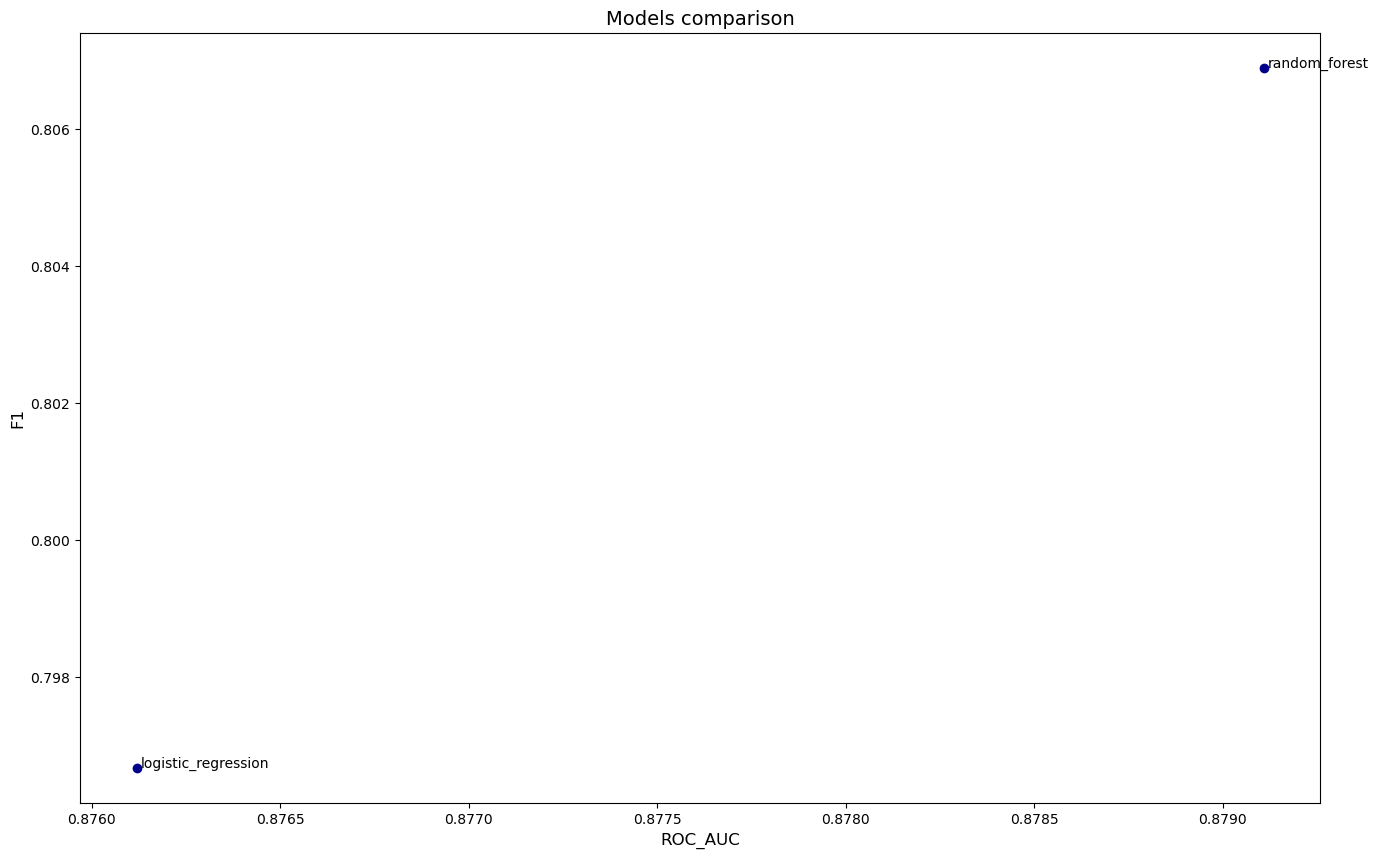

In [17]:
results.sort_values(by='f1', ascending=False, inplace=True)
display(results)

ax = results.set_index('roc_auc')['f1'].plot(style='o', c = 'DarkBlue', figsize = (16, 10)) # вместо scatter
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+0.00001, point['y']+0.00001, str(point['val']))
        
ax.set_xlabel('ROC_AUC', fontsize=12)
ax.set_ylabel('F1', fontsize=12)
ax.set_title('Models comparison', fontsize=14)

label_point(results['roc_auc'], results['f1'], results.index.to_series(), ax) # вместо annotate

plt.show()

In [31]:
best_models_name = results.iloc[0].name

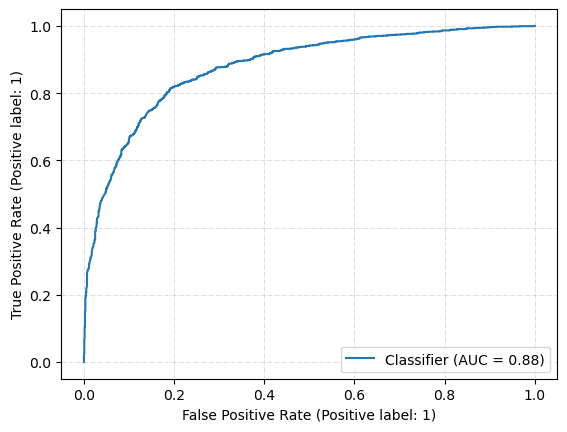

In [32]:
if results.iloc[0].name == 'random_forest':
    RocCurveDisplay.from_predictions(y_val_tree, models[best_models_name].predict_proba(X_val_tree)[:, 1])
    plt.grid(True, linestyle='-.', linewidth=0.5, alpha=0.6)
elif results.iloc[0].name == 'logistic_regression':
    RocCurveDisplay.from_predictions(y_val_log, models[best_models_name].predict_proba(X_val_log)[:, 1])
    plt.grid(True, linestyle='-.', linewidth=0.5, alpha=0.6)

Precision: 0.788764
Recall: 0.825882


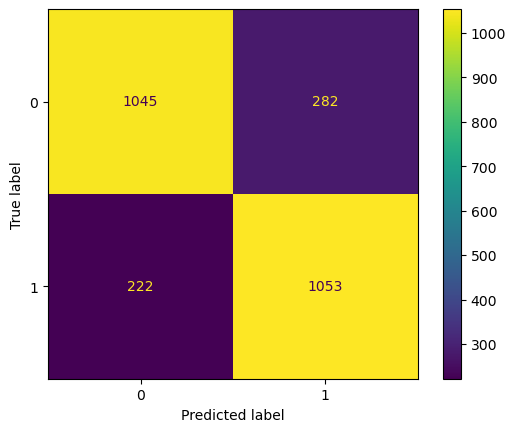

In [33]:
print(f'Precision: {custom_threshold_scorer(models[best_models_name], X_val_tree, y_val_tree, 0.5, precision_score):.6f}')
print(f'Recall: {custom_threshold_scorer(models[best_models_name], X_val_tree, y_val_tree, 0.5, recall_score):.6f}')

y_probs = models[best_models_name].predict_proba(X_val_tree)[:, 1]
y_pred = (y_probs >= 0.5).astype(int)

conf_matrix = confusion_matrix(y_val_tree, y_pred)
ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=models[best_models_name].classes_).plot()
plt.show()

---

In [34]:
joblib_logr = 'models/best_model.pkl'
joblib.dump(models[best_models_name], joblib_logr)

['models/best_model.pkl']